# Overview of the Lower-Level nmrsim API

## Under Construction

This notebook gives a tour of some of the lower-level API functions. We recommend that you start with the [**API-Introduction.ipynb**](./API-Introduction.ipynb) notebook for a higher-level overview.

In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'svg'  # makes inline plot look less blurry

In [3]:
home_path = os.path.abspath(os.path.join('..'))
if home_path not in sys.path:
    sys.path.append(home_path)

In [4]:
tests_path = os.path.abspath(os.path.join('..', 'tests'))
if tests_path not in sys.path:
    sys.path.append(tests_path)

In [5]:
from nmrsim import plt, qm

## Scenario: user wants to plot a spectrum for an ABX 3-spin system.


The API-Introduction notebook shows a simulation of an ABX 3-spin system using the SpinSystem class. Here, the simulation will be performed first with higher-level functions that take frequency(v) and intensity(J) arguments and return peaklists.

In [6]:
# This dataset is for the vinyl group of vinyl acetate, as used in:
# http://www.users.csbsju.edu/~frioux/nmr/ABC-NMR-Tensor.pdf
def rioux():
    v = np.array([430.0, 265.0, 300.0])
    J = np.zeros((3, 3))
    J[0, 1] = 7.0
    J[0, 2] = 15.0
    J[1, 2] = 1.50
    J = J + J.T
    return v, J

In [7]:
v, J = rioux()
print('v: ', v)  # frequencies in Hz
print('J: \n', J)  # matrix of coupling constants

v:  [430. 265. 300.]
J: 
 [[ 0.   7.  15. ]
 [ 7.   0.   1.5]
 [15.   1.5  0. ]]


The J matrix is constructed so that J[a, b] is the coupling constant between v[a] and v[b]. The diagonal elements should be 0.

### Method 1: using qm_spinsystem

In [8]:
abx_system = qm.qm_spinsystem(v, J)
abx_system

[(260.66152857482973, 0.2301124913178771),
 (291.31911366903165, 0.22882003310401944),
 (419.5193577561387, 0.2910724454555947),
 (292.84688854093866, 0.2138123115725166),
 (426.4877446901903, 0.2662986769673389),
 (262.1893034467368, 0.24876061726413515),
 (434.5231959501799, 0.23004586196807364),
 (267.62991550888137, 0.24855578963215708),
 (306.32295186307283, 0.2925168028407964),
 (441.49158288423155, 0.21257278181929298),
 (307.85072673497996, 0.2648680204713064),
 (269.1576903807885, 0.2725641675868919)]

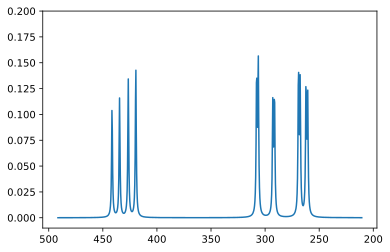

In [9]:
plt.mplplot(abx_system, y_max=0.2);

*{`qm_spinsystem` is a wrapper that selects one of two functions to perform the calculation: `qm.secondorder_dense` and `qm.secondorder_sparse`. With the default qm_spinsystem keyword arguments `cache=True` and `sparse=True`, the faster function `secondorder_sparse` is used. However, if at some point the sparse library becomes unavailable, or if caching of partial solutions is not possible, the slower `secondorder_dense` function will be used. These functions can also be used as direct swap-ins for `qm_spinsystem`.}*

### Method 2: via the spin Hamiltonian
This is not recommended for casual users, but may be of interest for teaching NMR theory, or if you want to take control of the process (e.g. obtain a Hamiltonian, and then simulate a spin pulse with it {a feature not currently implemented in `nmrsim`}). A description of the math behind the qm simulations is in the **qm_explanation.ipynb notebook** (currently under construction).

There are two versions of the Hamiltonian constructor. `qm.hamiltonian_sparse` uses cached sparse arrays for faster speed, and `qm.hamiltonian_dense` does not. Here we will use the former.

In [10]:
H = qm.hamiltonian_sparse(v, J)
print(H)
print(H.todense())

<COO: shape=(8, 8), dtype=complex128, nnz=20, fill_value=0j>
[[ 503.375+0.j    0.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j
     0.   +0.j    0.   +0.j    0.   +0.j]
 [   0.   +0.j  195.125+0.j    0.75 +0.j    0.   +0.j    7.5  +0.j
     0.   +0.j    0.   +0.j    0.   +0.j]
 [   0.   +0.j    0.75 +0.j  234.125+0.j    0.   +0.j    3.5  +0.j
     0.   +0.j    0.   +0.j    0.   +0.j]
 [   0.   +0.j    0.   +0.j    0.   +0.j  -72.625+0.j    0.   +0.j
     3.5  +0.j    7.5  +0.j    0.   +0.j]
 [   0.   +0.j    7.5  +0.j    3.5  +0.j    0.   +0.j   62.375+0.j
     0.   +0.j    0.   +0.j    0.   +0.j]
 [   0.   +0.j    0.   +0.j    0.   +0.j    3.5  +0.j    0.   +0.j
  -230.875+0.j    0.75 +0.j    0.   +0.j]
 [   0.   +0.j    0.   +0.j    0.   +0.j    7.5  +0.j    0.   +0.j
     0.75 +0.j -199.875+0.j    0.   +0.j]
 [   0.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j
     0.   +0.j    0.   +0.j -491.625+0.j]]


SpinSystem defaults to second-order simulation of a spin system. If the SpinSystem object is instantiated with the `second_order=False` keyword argument, or if the SpinSystem.second_order attribute is set to `False`, first-order simulation will be performed instead.

`qm.solve_hamilton` accepts a *dense* Hamiltonian array and the number of spins in the system, to give a peaklist:

In [11]:
peaklist = qm.solve_hamiltonian(H.todense(), nspins=3)
peaklist

array([[260.66152857,   0.92044387],
       [291.31911367,   0.91527407],
       [419.51935776,   1.16428207],
       [292.84688854,   0.85524358],
       [426.48774469,   1.06518765],
       [262.18930345,   0.99503588],
       [434.52319595,   0.92017735],
       [267.62991551,   0.99421657],
       [306.32295186,   1.17005946],
       [441.49158288,   0.85028549],
       [307.85072673,   1.05946506],
       [269.15769038,   1.09024945]])

To normalize the intensities so that they add up to 3 (the number of nuclei in the spin system), use `nmrsim.math.normalize_peaklist`:

In [12]:
from nmrsim.math import normalize_peaklist
plist_normalized = normalize_peaklist(peaklist, 3)
plist_normalized

[(260.66152857482973, 0.2301124913178771),
 (291.31911366903165, 0.22882003310401944),
 (419.5193577561387, 0.2910724454555947),
 (292.84688854093866, 0.2138123115725166),
 (426.4877446901903, 0.2662986769673389),
 (262.1893034467368, 0.24876061726413515),
 (434.5231959501799, 0.23004586196807364),
 (267.62991550888137, 0.24855578963215708),
 (306.32295186307283, 0.2925168028407964),
 (441.49158288423155, 0.21257278181929298),
 (307.85072673497996, 0.2648680204713064),
 (269.1576903807885, 0.2725641675868919)]

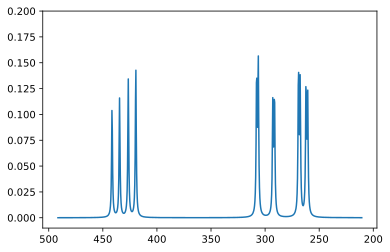

In [13]:
plt.mplplot(plist_normalized, y_max=0.2);

### Method 3: using a discrete mathematical solution
The `nmrsim.discrete` module has discrete solutions for some common spin systems. Some are exact (such as discrete.AB for AB quartets) while others are approximations (e.g. `partial.ABX` for an ABX system) or return only part of the solution (e.g. `partial.AAXX` for an AA'XX' system).

The `partial.ABX` function uses an approximation that assumes the X nucleus is very far away in chemical shift from A and B. If accuracy is required, use a second-order calculation instead.

The functions in `nmrsim.discrete` also take different arguments than those usual throughout the rest of the nmrsim library. They are derived from similar functions in [Hans Reich's WINDNMR program](https://www.chem.wisc.edu/areas/reich/plt/windnmr.htm) and use similar inputs.

In [14]:
from nmrsim.discrete import ABX
help(ABX)

Help on function ABX in module nmrsim.discrete:

ABX(Jab, Jax, Jbx, Vab, Vcentr, vx, normalize=True)
    Non-QM approximation for an ABX spin system. The approximation assumes
    that Hx is very far away in chemical shift from Ha/Hb.
    
    Parameters
    ---------
    Jab : float
        The Ha-Hb coupling constant (Hz).
    Jbx : float
        The Ha-Hb coupling constant (Hz).
    Jax : float
        The Ha-Hb coupling constant (Hz).
    Vab : float
        The difference in the frequencies (in the absence of
        coupling) of Ha and Hb (Hz).
    Vcentr : float
        The frequency (Hz) for the center of the AB signal.
    vx : float
        The frequency (Hz) for Hx in the absence of coupling.
    
    normalize: bool (optional)
        whether the signal intensity should be normalized. If false, the total
        signal intensity happens to be ~12.
    
    Returns
    -------
    [(float, float)...]
        a list of (frequency, intensity) tuples.



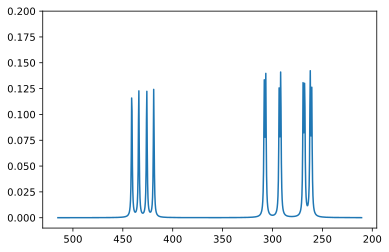

In [15]:
peaklist = ABX(1.5, 7, 15, (265-300), ((265+300)/2), 430)  # JAB, JAX, JBX, Vab, Vcentr, vx
plt.mplplot(peaklist, y_max=0.2);

### Method 4: a first-order simulation 
The same v/J arguments can be used by `nmrsim.firstorder.first_order_spin_system` to return a peaklist for a first-order simulation:

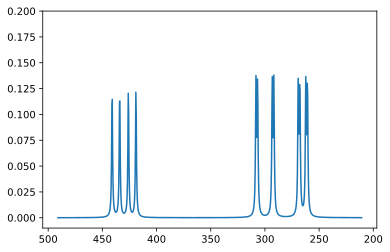

In [16]:
from nmrsim.firstorder import first_order_spin_system
peaklist = first_order_spin_system(v, J)
plt.mplplot(peaklist, y_max = 0.2);

Individual multiplets can also be modeled using `nmrsim.firstorder.multiplet`. For example, for the X part of the ABX system as a first-order signal, i.e. 430 Hz, 1H, dd, *J* = 15, 7 Hz:

[(419.0, 0.25), (426.0, 0.25), (434.0, 0.25), (441.0, 0.25)]


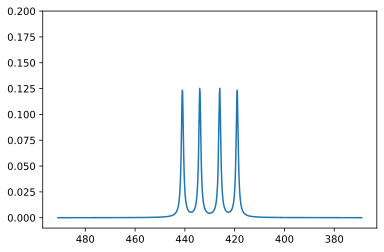

In [17]:
from nmrsim.firstorder import multiplet
X = multiplet((430, 1), [(15, 1), (7, 1)])  # args (frequency, integration), [(J, # of couplings)...]
print(X)
plt.mplplot(X, y_max=0.2);

### Scenario: modeling DNMR spectra

The nmrsim.dnmr module provides functions as well as classes for the computation of DNMR lineshapes. Currently there are models for two systems: two uncoupled spins (`dnmr.dnmr_two_singlets`), and two coupled spins (`dnmr.dnmr_AB`, i.e an AB or AX system at the slow-exchange limit). 

In [18]:
from nmrsim.dnmr import dnmr_two_singlets
help(dnmr_two_singlets)

Help on function dnmr_two_singlets in module nmrsim.dnmr:

dnmr_two_singlets(va, vb, ka, wa, wb, pa, limits=None, points=800)
    Create a the lineshape for a DNMR spectrum of two uncoupled spin-half
    nuclei.
    
    Parameters
    ----------
    va, vb : int or float
        The frequencies (Hz) of nuclei 'a' and 'b' at the slow exchange limit.
    ka : int or float
        The rate constant (Hz) for state a--> state b
    wa, wb : int or float
        The peak widths at half height for the 'a' and 'b' singlets at the
        slow-exchange limit.
    pa : float (0 <= pa <= 1)
        The fraction of the population in state a
    limits : (int or float, int or float), optional
        The minimum and maximum frequencies (in any order) for the simulation.
    points : int
        The length of the returned arrays (i.e. the number of points plotted).
    
    Returns
    -------
    x, y : numpy.array, numpy.array
        Arrays for the x (frequency) and y (intensity) lineshape data 

In [19]:
frequency, intensity = dnmr_two_singlets(165, 135, 1.5, 0.5, 0.5, 0.5) # va, vb, ka, wa, wb, pa
frequency[:10], intensity[:10]

(array([85.        , 85.16270338, 85.32540676, 85.48811014, 85.65081352,
        85.8135169 , 85.97622028, 86.13892365, 86.30162703, 86.46433041]),
 array([1.21342220e-05, 1.22103165e-05, 1.22871542e-05, 1.23647452e-05,
        1.24430994e-05, 1.25222271e-05, 1.26021387e-05, 1.26828448e-05,
        1.27643561e-05, 1.28466836e-05]))

To plot lineshape data such as the above (a pair of lists, one for all x coordinates and one for the corresponding y coordinates), you can use the visualization library of your choice. For a quick matplotlib representation, you can use `nmrsim.plt.mplplot_lineshape`:

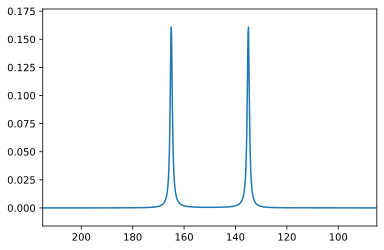

In [20]:
from nmrsim.plt import mplplot_lineshape
mplplot_lineshape(frequency, intensity);

Coalescence for this system occurs at k ~= 65.9 s<sup>-1</sup>:

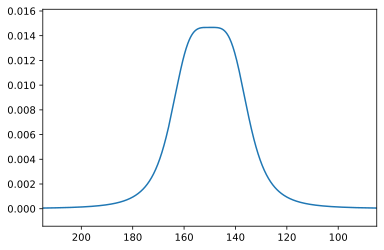

In [21]:
mplplot_lineshape(*dnmr_two_singlets(165, 135, 65.9, 0.5, 0.5, 0.5));